In [1]:
%pwd

'C:\\Users\\rodriguezr\\OneDrive - William Paterson University\\WP_Masters\\Ban7750-70_FinancialAnalytics\\Python\\assignment4\\A4'

### Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#pip install plotly-express
#import plotly.express as px
import seaborn as sns
import scipy.stats as stats
from scipy.stats import kurtosis
from scipy.stats import skew
import math
import matplotlib
import pandas.plotting
from IPython import display
from ipywidgets import interact, widgets
sns.set_style('ticks')
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression as lr
import re
import math
from IPython.core.display import display, HTML
# This command will activate multiline output [you could also use display()]
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [3]:
# Read Trading Analytics CSV
taData = pd.read_csv("Trading Analytics.csv")
# Drop (discard) Columns per Notes
taData = taData.drop(columns = [' Volume', ' TradeTime', ' EventTime', ' Offer',
       ' Bid', ' Buyer', ' Seller', ' buyerID', ' sellerID', ' R per Tr ', 'U per tr Q', ' Unreal Tot $ ', '1stHour?', 'lastHour?', '1stHR_Usr/TOT_vol', 'lastH-Usr/TOT_vol', 'Range',
       '(p2/p1)-1', 'ln(p2/p1)', 'Volat = stdev of LN'])
# Read Survey Data
sData = pd.read_excel("Survey_clean.xlsx", sheet_name = "Combined", header = 0)

### Clean up Trading Analytics Columns

In [4]:
# Fix Columns w/ Leading (and Trailing) spaces and other un-friendly variable name characters
for i in range(len(taData.columns)):
    # Remove Spaces, -, +, (, ), ., *
    taData.columns.values[i] = re.sub(r"(\s|-|\+|\(|\)|\.|\*)","",taData.columns[i])
    # Remove % symbols w/ Pct
    taData.columns.values[i] = re.sub(r"%","Pct",taData.columns[i])
    # Replace 1st w/ First
    taData.columns.values[i] = re.sub(r"1st","First",taData.columns[i])
    # Replace / w/ _per_
    taData.columns.values[i] = re.sub(r"/","_per_",taData.columns[i])
    # Replace Volu w/ just Vol
    taData.columns.values[i] = re.sub(r"Volu","Vol",taData.columns[i])
#taData.columns
taData = taData.rename(columns = {"IDo":"ID"})
# Remove any spaces found within ID variable
taData.ID = [re.sub(r"\s","",iD) for iD in taData.ID]
# Look for any IDs missing a 'C', and if it is insert
for i in range(len(taData)):
    if(taData.loc[i,"ID"].find("C") < 0):
        iD = taData.loc[i,"ID"]
        taData.loc[i,"ID"] = iD[:2] + "C" + iD[2:6]

### Clean up Survery Data Columns

In [5]:
# Rename Columns 0, 1, & 2
sData.columns.values[0] = "ID"
sData.columns.values[1] = "Gender"
sData.columns.values[2] = "Strategy"

#sData.Strategy.unique()
#sData.Q1.unique()
# Create a JSON object for mapping the Question responses into numeric values
QRespMap = {'Strongly Agree' : 5, 'Agree' : 4, 'Neither Agree nor Disagree' : 3, 'Disagree' : 2, 'Strongly Disagree' : 1}
# Create a JSON object for mapping the Strategy as a Dummy Variable
StratMap = {'SELL FIRST AND THEN BUY LATER to make profit (when Stock price is going to DECREASE towards the end of the day)' : 0, 'BUY FIRST AND THEN SELL LATER to make profit (when Stock price is going to INCREASE towards the end of the day)' : 1}
#sData.Q1.astype("category")
# Loop through Columns and covert to ordinal values
for col in sData.columns:
    sData[col].replace(StratMap, inplace = True)
    sData[col].replace(QRespMap, inplace = True)
    sData[col].replace({'Yes' : 1, 'No' : 0}, inplace = True)

# Extract the Questions from the first [0] row 
Qs = sData.iloc[0,3:]
# Then we can drop this row from our data frame
if(type(sData.ID[0]) == float):
    if(math.isnan(sData.ID[0])):
        sData = sData.drop(0, axis = 0)
        # Reset the index, after dropping row 0
        sData = sData.reset_index(drop = True)
# Remove any spaces found within ID variable
sData.ID = [re.sub(r"\s","",iD) for iD in sData.ID]
# Look for any IDs missing a 'C', and if it is insert
for i in range(len(sData)):
    if(sData.loc[i,"ID"].find("C") < 0):
        iD = sData.loc[i,"ID"]
        sData.loc[i,"ID"] = iD[:2] + "C" + iD[2:6]

### List of all the Survey Questions

In [6]:
for q in Qs.index:
    print(q + ": " + Qs[q])

Q4: I traded based on price movements indicated on the TraderEx screen
Q5: I was not concerned about price movements indicated on the TraderEx screen
Q1: I traded without considering the information pieces provided to me
Q2: I traded using ALL of the information provided to me at each stage
Q3: I traded using SOME of the information provided to me at each stage
Q6: I did my best to win the maximum possible reward of $ 50.00
Q7: I did my best to win at least one of the cash rewards of $ 5 or $ 10 but did not focus on $ 50
Q8: I did not want the cash rewards at all
Q9: I believe that I can improve on my net profits if I had more information even if I did not have any technological tools to analyze the information
Q10: I believe that I can improve on my net profits if I had more technological tools for analysis even if I did not have any additional information
Q11: I believe that I can improve on my net profits if I had more 
technological tools for analysis along with more information
Q1

### Drop Duplicate IDs from both datasets


In [7]:
# Drop rows with duplicate IDs from trading_analysis dataset
taData = taData.drop_duplicates(subset = "ID")
# Drop rows with duplicate IDs from survey dataset
sData = sData.drop_duplicates(subset = "ID")

### Merge the two dataframes by the ID

In [8]:
data = taData.merge(sData, left_on = "ID", right_on = "ID")
#if(len(data.ID.unique()) == len(data)):
    # Display Smiley Face if the IDs are unique throughout the merged dataset
    #display(HTML("<p>Each row has it's own unique ID <br /><span style='font-size:50px;'>&#128515;</span></p>"))
#else:
    # Display Confused Face if the IDs are NOT unique throughout the merged dataset
   # display(HTML("<p>There appears to some rows w/ duplicate IDs <span style='font-size:100px;'>&#128533;</span></p>"))
# Create New Variable "Desk"
data["Desk"] = [iD[0:iD.find("C")] for iD in data.ID]
# Create New Variable TraderID
data["TraderID"] = [iD[iD.find("C"):] for iD in data.ID]
# Convert Gender, Strategy, and Question variables to Category 
for col in ['Gender', 'Strategy', 'Q4', 'Q5', 'Q1', 'Q2', 'Q3', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11', 'Q12', 'Q13', 'Q14', 'Q15', 'Q16', 'Q17', 'Q18', 'Q19', 'Q20', 'Q21', 'Q22', 'Q23', 'Q24', 'Q26', 'Q27', 'Q45', 'Q28', 'Q47', 'Q29', 'Q30']:
    data[col] = data[col].astype("category")
#data.info()

In [9]:
#data.info(verbose = True, null_counts = False)

In [10]:
data = data.drop(columns = ['Unnamed:40','Unnamed:41', 'Unnamed:42', 'Unnamed:43', 
                            'Unnamed:44', 'Unnamed:45', 'Unnamed:46','Unnamed:47',
                            'Unnamed:48', 'Unnamed:49', 'Unnamed:50',])

#print(data.head())

<h3>Exploratory</h3>

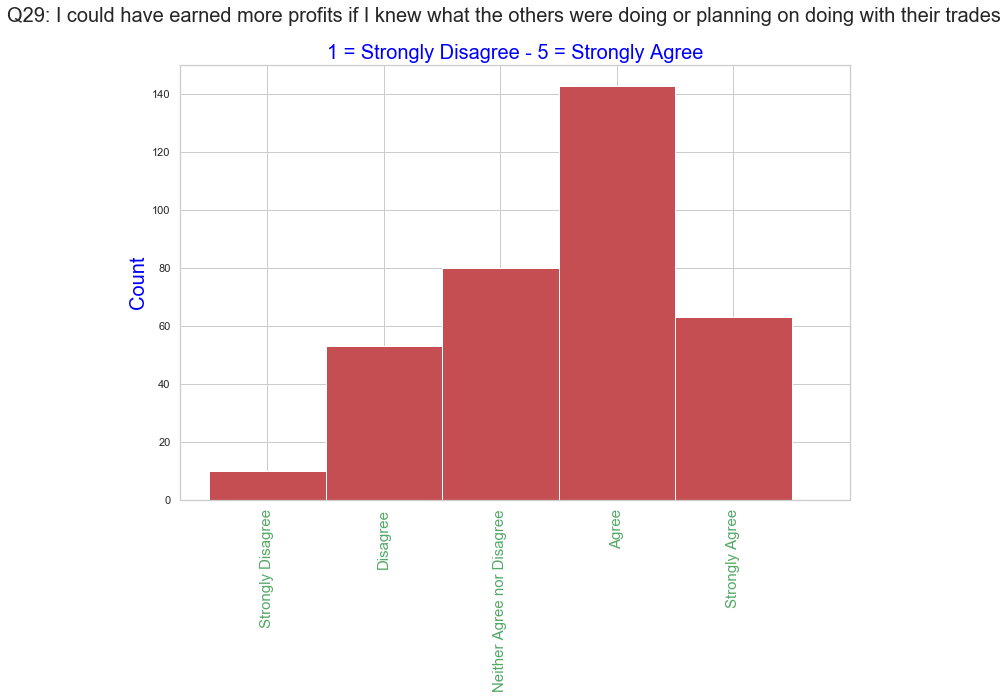

In [11]:
ticks = ['Strongly Disagree', 'Disagree', 'Neither Agree nor Disagree', 'Agree', 'Strongly Agree']
bins = np.arange(1,7)
#for q in Qs.index:

fig = plt.figure(figsize=(12, 8))
p =data["Q29"].hist(bins = bins, align = "left",color="r");
n =plt.suptitle("Q29" + ": " + Qs["Q29"],fontsize=20);
plt.title("1 = Strongly Disagree - 5 = Strongly Agree", color="blue", fontsize=20, y=1)
n =plt.xticks(bins, ticks, color = "g", fontsize=15,rotation=90);
n =plt.ylabel("Count", color="blue", fontsize=20);
plt.show();


In [12]:
#data.describe().T

In [13]:
from plotly.offline import init_notebook_mode, iplot
import plotly.figure_factory as ff
#pip install cufflinks
#import cufflinks
#cufflinks.go_offline()
#cufflinks.set_config_file(world_readable=True, theme='pearl')
import plotly.graph_objs as go
import chart_studio.plotly as py
import plotly
from plotly import tools
#plotly.tools.set_credentials_file(username='XXX', api_key='XXX')
init_notebook_mode(connected=True)
pd.set_option('display.max_columns', 100)

View the following in notebook only doen't work well with Jupyterlabs. 

In [14]:
table_cat = ff.create_table(data.describe(include=['O']).T, index=True, index_title='Categorical columns')
iplot(table_cat)

In [15]:
#print(data.Desk.head(3))
#print(data.TraderID.head(3))

In [55]:
data['Desk'].iplot(
    kind='hist',
    bins=100,
    xTitle='Groups',
    linecolor='black',
    yTitle='count',
    title='Number of participant in each Desk')

In [17]:
import pandas as pd
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 
init_notebook_mode(connected=True)

init_notebook_mode(connected=True)
cf.go_offline()

In [18]:
df1 = data.groupby('Q29')['Desk']
df1.describe()

,count,unique,top,freq
Q29,,,,
1,10,6,S6,2
2,53,9,S3,10
3,80,10,S10,16
4,143,10,S5,25
5,63,9,S6,16


In [19]:

xt = data.Q29.value_counts()
xt/xt.sum()


4    0.409742
3    0.229226
5    0.180516
2    0.151862
1    0.028653
Name: Q29, dtype: float64

In [20]:
#question 29
count_strongly_DisA = len(data[data['Q29']==1]) # strongly disagree
count_DisA = len(data[data['Q29']==2]) #disagree
count_neitherDA = len(data[data['Q29']==3]) #neither agree or disagree
count_A = len(data[data['Q29']==4]) # agree
count_strongly_A = len(data[data['Q29']==5]) #strongly Agree

pct_of_strongly_DisA = count_strongly_DisA/(count_strongly_DisA+count_DisA+count_neitherDA+count_A+count_strongly_A)

print("percentage of participant who strongly disagrees with Q29 is", pct_of_strongly_DisA*100)

pct_of_Disagree = count_DisA/(count_strongly_DisA+count_DisA+count_neitherDA+count_A+count_strongly_A)

print("percentage of participant who disagrees with Q29 is", pct_of_Disagree*100)

pct_of_neitherDA = count_neitherDA/(count_strongly_DisA+count_DisA+count_neitherDA+count_A+count_strongly_A)
print("percentage of participant who neither disagrees or agrees with Q29 is", pct_of_neitherDA*100)

pct_of_Agree = count_A/(count_strongly_DisA+count_DisA+count_neitherDA+count_A+count_strongly_A)
print("percentage of participant who agrees with Q29 is", pct_of_Agree*100)

pct_of_Strongly_Agree = count_strongly_A/(count_strongly_DisA+count_DisA+count_neitherDA+count_A+count_strongly_A)
print("percentage of participant who strongly agrees with Q29 is", pct_of_Strongly_Agree*100)


percentage of participant who strongly disagrees with Q29 is 2.865329512893983
percentage of participant who disagrees with Q29 is 15.18624641833811
percentage of participant who neither disagrees or agrees with Q29 is 22.922636103151863
percentage of participant who agrees with Q29 is 40.97421203438395
percentage of participant who strongly agrees with Q29 is 18.05157593123209


In [21]:
ag = data.groupby('Q29').Desk.value_counts().sort_index()

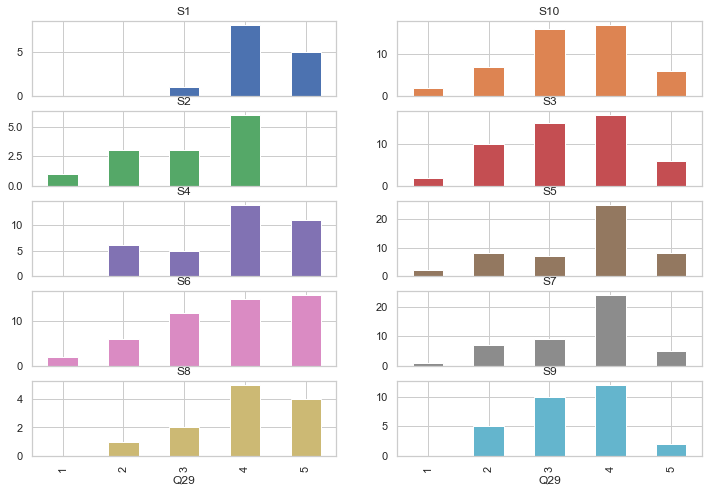

In [22]:

ag.unstack().plot(kind='bar', subplots=True, layout=(5,2),figsize=(12, 8),legend=None);

In [23]:
df4 = data.groupby(["Desk", "Q29"])["Strategy"]
df4 = df4.value_counts()
df4 = df4.unstack()
df4 = df4.apply(lambda x: x/x.sum(), axis=1)
#print(df4.to_string(float_format="%.3f"))
df5 =(df4.to_string(float_format="%.3f"))
print(df5)

Strategy     0     1
Desk Q29            
S1   3   1.000   NaN
     4   0.250 0.750
     5   0.400 0.600
S10  1     NaN 1.000
     2   0.143 0.857
     3   0.188 0.812
     4   0.176 0.824
     5   0.500 0.500
S2   1     NaN 1.000
     2     NaN 1.000
     3   1.000   NaN
     4   0.500 0.500
S3   1     NaN 1.000
     2   0.100 0.900
     3   0.333 0.667
     4   0.118 0.882
     5     NaN 1.000
S4   2   0.333 0.667
     3     NaN 1.000
     4   0.071 0.929
     5   0.182 0.818
S5   1     NaN 1.000
     2   0.250 0.750
     3   0.286 0.714
     4   0.240 0.760
     5   0.500 0.500
S6   1   1.000   NaN
     2   0.500 0.500
     3   0.333 0.667
     4   0.267 0.733
     5   0.500 0.500
S7   1     NaN 1.000
     2   0.571 0.429
     3   0.333 0.667
     4   0.417 0.583
     5   0.200 0.800
S8   2   1.000   NaN
     3   0.500 0.500
     4   0.400 0.600
     5   1.000   NaN
S9   2   0.600 0.400
     3   0.200 0.800
     4   0.417 0.583
     5   0.500 0.500


In [24]:
#crosstab strategy and data
#of the strategy used per desk 
dfcrosstab = pd.crosstab(data.Strategy, data.Desk)
dfcrosstab.T

Strategy,0,1
Desk,,
S1,5,9
S10,10,38
S2,6,7
S3,8,42
S4,5,31
S5,14,36
S6,21,30
S7,18,28
S8,8,4


M    186
F    163
Name: Gender, dtype: int64

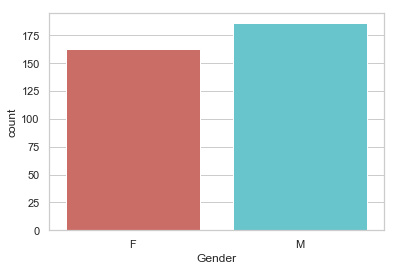

percentage of female participant is 46.70487106017192
percentage of male participant is 53.29512893982808


In [25]:
#getting a count of Males vs Females 
#without having to groupby 
gender = data["Gender"].value_counts()
gender

p= sns.countplot(x='Gender',data=data, palette='hls')
plt.show()
count_no_sub = len(data[data['Gender']=='F'])
count_sub = len(data[data['Gender']=='M'])
pct_of_no_sub = count_no_sub/(count_no_sub+count_sub)
print("percentage of female participant is", pct_of_no_sub*100)
pct_of_sub = count_sub/(count_no_sub+count_sub)
print("percentage of male participant is", pct_of_sub*100)

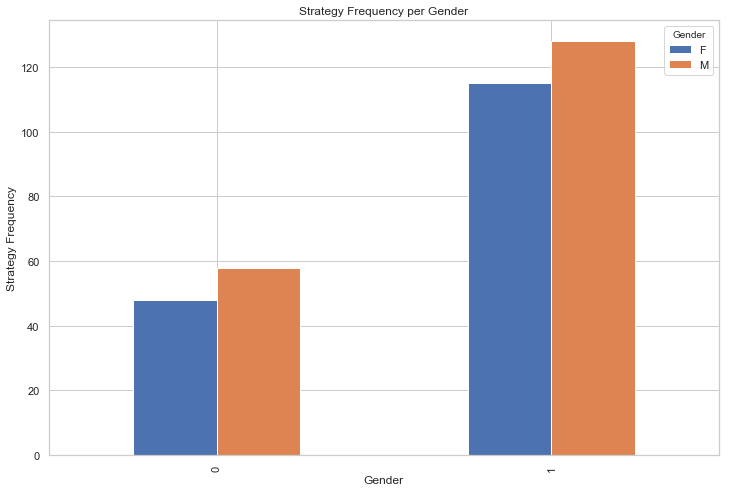

In [26]:
#getting a visual look at the strategy used by Gender
p=pd.crosstab(data.Strategy,data.Gender).plot(figsize=(12,8),kind='bar')
p=plt.title('Strategy Frequency per Gender')
p=plt.xlabel('Gender')
p=plt.ylabel('Strategy Frequency')
#plt.savefig('Strategy_Gender')

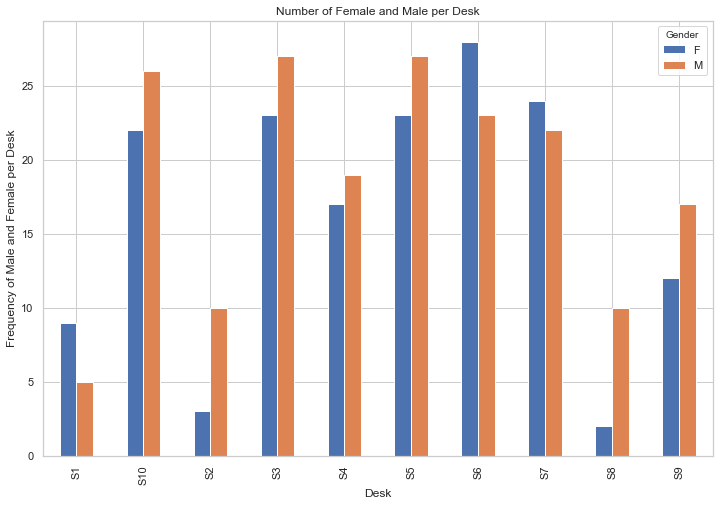

In [27]:
p=pd.crosstab(data.Desk,data.Gender).plot(figsize=(12,8),kind='bar')
p=plt.title('Number of Female and Male per Desk')
p=plt.xlabel('Desk')
p=plt.ylabel('Frequency of Male and Female per Desk')
#plt.savefig('Gender_Desk')

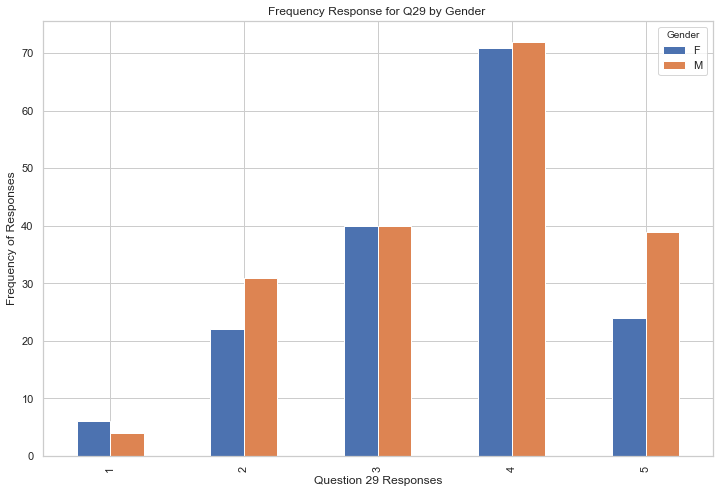

In [28]:
#plot shows how many times a male or female choose one of the reponses 
p=pd.crosstab(data.Q29,data.Gender).plot(figsize=(12,8),kind='bar')
p=plt.title('Frequency Response for Q29 by Gender ')
p=plt.xlabel('Question 29 Responses')
p=plt.ylabel('Frequency of Responses')
#plt.savefig('Q29_Gender')

<Figure size 432x288 with 0 Axes>

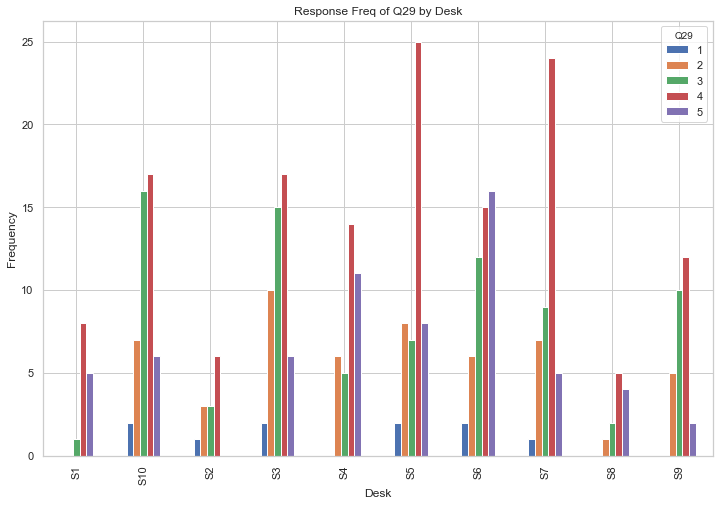

In [29]:
p = plt.figure()
p = pd.crosstab(data.Desk,data.Q29).plot(figsize=(12,8), kind='bar') 
p = plt.title("Response Freq of Q29 by Desk")
p = plt.xlabel('Desk')
p = plt.ylabel('Frequency')
#plt.savefig('pur_fre_month_bar')

In [30]:
#data.groupby('Gender').mean().T

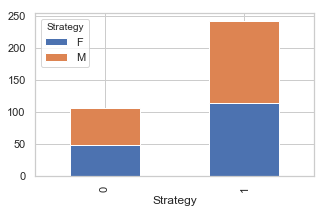

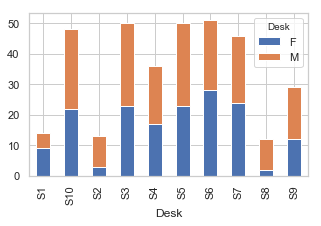

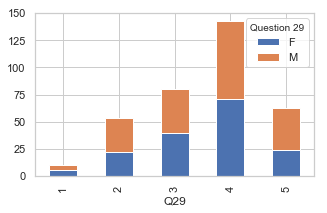

In [31]:
ct = pd.crosstab(data.Strategy, data.Gender)
#print(ct)
ct2 = pd.crosstab(data.Desk, data.Gender)
#print(ct2)
ct3 = pd.crosstab(data.Q29, data.Gender)
#print(ct3)

p= ct.plot.bar(stacked=True, figsize=(5,3));
p= plt.legend(title='Strategy');

p= ct2.plot.bar(stacked=True, figsize=(5,3));
p= plt.legend(title='Desk');
p =ct3.plot.bar(stacked=True, figsize=(5,3));
p= plt.legend(title='Question 29');
plt.show()

In [32]:
#data.columns.values

In [33]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

## Logistic Regression

A logistic regression was done using Q29 as the dependent variable. 
We created a copy of the dataset into a new dataframe called datacopy and began dropping the categorical variables from it.  We also did some additional cleanup removing strings like percent signs from ['FirstHR_Usr_per_1SThR_Tot'] and ['UserPctofTotalVol'] and converting them into data type float. 


In [34]:
# creating a copydata for our sample dataset to do a logistic regression
datacopy = data
#print(datacopy)
# dropping null value columns to avoid errors 
datacopy.dropna(inplace = True) 

datacopy = datacopy.drop(columns = ['ID','TraderID','lastHUsr_per_LASTHRTot','Qualify','Gender','Desk'])

datacopy['UserPctofTotalVol'] = (datacopy['UserPctofTotalVol'].str.strip('%').astype(float))
datacopy['FirstHR_Usr_per_1SThR_Tot'] = (datacopy['FirstHR_Usr_per_1SThR_Tot'].str.strip('%').astype(float))
#datacopy['lastHUsr_per_LASTHRTot'] = (datacopy['lastHUsr_per_LASTHRTot'].str.strip('%').str.strip('#DIV/0!').astype(int))
#print(datacopy.head())
  

Before the Logistic regression was run, Q29 was modified from the likert scale to binary values. The likert values of 1 and 2 were recoded to 0 and the likert values of 3, 4, and 5 were recoded to 1. 

In [35]:
datacopy['Q29'] = datacopy['Q29'].map({ 1:0,2:0,3:1,4:1,5:1})

### Over-sampling to balance our data
Over-sampling using SMOTE With our training data created,
Sampling Q29 using the SMOTE algorithm (Synthetic Minority Oversampling Technique). At a high level, SMOTE:
Works by creating synthetic samples from Q29 instead of creating copies.
Randomly choosing one of the k-nearest-neighbors and using it to create a similar, but randomly tweaked, new observations. Using SMOTE in Python.

In [36]:

#datacopy['Q29'] = datacopy['Q29'].map({ 1:0,2:0,3:1,4:1,5:1})
X = datacopy.loc[:, datacopy.columns != 'Q29']
y = datacopy.loc[:, datacopy.columns == 'Q29']
from imblearn.over_sampling import SMOTE
#pip install imblearn
os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns
os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['y'])
# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))

print("number disagree",len(os_data_y[os_data_y['y']==0]))

print("Number of agree",len(os_data_y[os_data_y['y']==1]))

print("Proportion disagree data in oversampled data is ",len(os_data_y[os_data_y['y']==0])/len(os_data_X))

print("Proportion of agree data in oversampled data is ",len(os_data_y[os_data_y['y']==1])/len(os_data_X))




length of oversampled data is  396
number disagree 198
Number of agree 198
Proportion disagree data in oversampled data is  0.5
Proportion of agree data in oversampled data is  0.5


As you can see from the above output our data is now balanced. You may have noticed that we over-sampled only on the training data, because by oversampling only on the training data, none of the information in the test data is being used to create synthetic observations, therefore, no information will bleed from test data into the model training.
### Recursive Feature Elimination
Recursive Feature Elimination (RFE) is based on the idea to repeatedly construct a model and choose either the best or worst performing feature, setting the feature aside and then repeating the process with the rest of the features. This process is applied until all features in the dataset are exhausted. The goal of RFE is to select features by recursively considering smaller and smaller sets of features.

In [37]:
data_vars=datacopy.columns.values.tolist()
y=['Q29']
X=[i for i in data_vars if i not in y]
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
rfe = RFE(logreg, 20)
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

[ True False False False False False False False False False False False
  True False False False False False False  True False False  True False
 False  True  True False  True False False  True  True  True  True False
  True  True False  True  True  True  True False  True  True  True False
 False]
[ 1 23 21 25 14 17 15 26 27 29 24 13  1 30 19 18 20 16 22  1  4  3  1  7
  8  1  1  6  1 10 12  1  1  1  1  9  1  1  5  1  1  1  1  2  1  1  1 11
 28]


In [38]:
#printing the varibles to match them to True above.
print(data_vars)

['Price', 'RealizedTot', 'UnRealQ', 'UserVol', 'UserPctofTotalVol', 'TotalVol', 'TradeCount', 'FirstHourVol', 'FirstHourUserVol', 'lastHourVol', 'lastHourUserVol', 'FirstHR_Usr_per_1SThR_Tot', 'VWAP', 'PriceV', 'Net', 'UserBuy', 'UserSell', 'UserVolTradedBuySell', 'Strategy', 'Q4', 'Q5', 'Q1', 'Q2', 'Q3', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11', 'Q12', 'Q13', 'Q14', 'Q15', 'Q16', 'Q17', 'Q18', 'Q19', 'Q20', 'Q21', 'Q22', 'Q23', 'Q24', 'Q26', 'Q27', 'Q45', 'Q28', 'Q47', 'Q29', 'Q30']


The RFE has helped us select the following varible for our model

In [39]:
#Adding the variable from above slect by RFE
cols=['Price', 'VWAP','Strategy', 'Q5', 'Q2','Q8','Q11','Q12','Q13','Q14','Q15','Q20','Q23','Q24','Q26','Q27','Q45','Q47'] 
X=os_data_X[cols]
y=os_data_y['y']

In [40]:
import statsmodels.api as sm
logit_model=sm.Logit(y,X.astype(float))
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.577802
         Iterations 6
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.166     
Dependent Variable: y                AIC:              493.6189  
Date:               2019-08-07 16:19 BIC:              565.2843  
No. Observations:   396              Log-Likelihood:   -228.81   
Df Model:           17               LL-Null:          -274.49   
Df Residuals:       378              LLR p-value:      3.4604e-12
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     6.0000                                       
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
Price          0.6833    0.4081   1.6742  0.0941  -0.1166   1.4831
VWAP          -0.9781    0.4264  -2.2935  0.0218  -1.8139  -0.

In [41]:
# creating a copydata for our sample dataset to do a logistic regression
datacopy = data
#print(datacopy)
# dropping null value columns to avoid errors 
datacopy.dropna(inplace = True) 

datacopy = datacopy.drop(columns = ['ID','TraderID','lastHUsr_per_LASTHRTot','Qualify','Gender','Desk'])

datacopy['UserPctofTotalVol'] = (datacopy['UserPctofTotalVol'].str.strip('%').astype(float))
datacopy['FirstHR_Usr_per_1SThR_Tot'] = (datacopy['FirstHR_Usr_per_1SThR_Tot'].str.strip('%').astype(float))
#datacopy['lastHUsr_per_LASTHRTot'] = (datacopy['lastHUsr_per_LASTHRTot'].str.strip('%').str.strip('#DIV/0!').astype(int))
#print(datacopy.head())
  

After some testing of the regression models, we  removed likert value 3 (neither disagree or agree) from the respones of Q29. Which then gave us better results on our logistic regressions. 

In [42]:
#data

In [43]:
datacopy['Q29'] = datacopy['Q29'].map({ 1:0,2:0,4:1,5:1})

In [44]:
datacopy.dropna(inplace = True)
X = datacopy.loc[:, datacopy.columns != 'Q29']
y = datacopy.loc[:, datacopy.columns == 'Q29']
from imblearn.over_sampling import SMOTE
#pip install imblearn
os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns
os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['y'])
# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))

print("number disagree",len(os_data_y[os_data_y['y']==0]))

print("Number of agree",len(os_data_y[os_data_y['y']==1]))

print("Proportion disagree data in oversampled data is ",len(os_data_y[os_data_y['y']==0])/len(os_data_X))

print("Proportion of agree data in oversampled data is ",len(os_data_y[os_data_y['y']==1])/len(os_data_X))



length of oversampled data is  280
number disagree 140
Number of agree 140
Proportion disagree data in oversampled data is  0.5
Proportion of agree data in oversampled data is  0.5


By dropping response 3 (neither disagree nor agree) from our binary the over-sample above changed from 396 to 280 giving us 140 agrees and 140 disagree.

In [45]:
data_vars=datacopy.columns.values.tolist()
y=['Q29']
X=[i for i in data_vars if i not in y]
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
rfe = RFE(logreg, 20)
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

[False False False False False False False False False False False False
  True False False False False False False  True  True False False False
  True False  True False False  True False  True  True  True  True  True
  True  True False False False  True  True  True  True  True False  True
  True]
[13 24 23 27 10 19 18 17 16 30 25  9  1 26 29 21 22 20  8  1  1 15 11  6
  1 28  1 12  5  1  7  1  1  1  1  1  1  1  4 14  3  1  1  1  1  1  2  1
  1]


In [46]:
print(data_vars)

['Price', 'RealizedTot', 'UnRealQ', 'UserVol', 'UserPctofTotalVol', 'TotalVol', 'TradeCount', 'FirstHourVol', 'FirstHourUserVol', 'lastHourVol', 'lastHourUserVol', 'FirstHR_Usr_per_1SThR_Tot', 'VWAP', 'PriceV', 'Net', 'UserBuy', 'UserSell', 'UserVolTradedBuySell', 'Strategy', 'Q4', 'Q5', 'Q1', 'Q2', 'Q3', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11', 'Q12', 'Q13', 'Q14', 'Q15', 'Q16', 'Q17', 'Q18', 'Q19', 'Q20', 'Q21', 'Q22', 'Q23', 'Q24', 'Q26', 'Q27', 'Q45', 'Q28', 'Q47', 'Q29', 'Q30']


Selecting new varibles above without repsonce 3 in Q29. 

In [47]:
cols=[ 'VWAP', 'Q4', 'Q5','Q6','Q8','Q11','Q12','Q13','Q14','Q15','Q16','Q17','Q18',
      'Q19','Q23','Q24','Q26','Q27','Q45','Q30'] 
X=os_data_X[cols]
y=os_data_y['y']

## Implementing the new model with out neutral participants

In [48]:
import statsmodels.api as sm
logit_model=sm.Logit(y,X.astype(float))
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.507594
         Iterations 6
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.268     
Dependent Variable: y                AIC:              324.2524  
Date:               2019-08-07 16:20 BIC:              396.9482  
No. Observations:   280              Log-Likelihood:   -142.13   
Df Model:           19               LL-Null:          -194.08   
Df Residuals:       260              LLR p-value:      1.0428e-13
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     6.0000                                       
-------------------------------------------------------------------
           Coef.    Std.Err.      z      P>|z|     [0.025    0.975]
-------------------------------------------------------------------
VWAP      -0.2957     0.0909   -3.2524   0.0011   -0.4740   -0.1175
Q4        -0.6666     0.2126   -3.1361   0.0017   -1.0832 

now to select the varible based on thier pvalue < 0.05 

In [49]:
#running the Logistic Regession based on pvalue less than 0.05
cols=[ 'VWAP', 'Q4', 'Q14','Q16','Q17','Q18',
      'Q19','Q26','Q45'] 

X=os_data_X[cols]
y=os_data_y['y']
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.550654
         Iterations 6
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.206     
Dependent Variable: y                AIC:              326.3660  
Date:               2019-08-07 16:20 BIC:              359.0791  
No. Observations:   280              Log-Likelihood:   -154.18   
Df Model:           8                LL-Null:          -194.08   
Df Residuals:       271              LLR p-value:      5.3725e-14
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     6.0000                                       
-------------------------------------------------------------------
           Coef.    Std.Err.      z      P>|z|     [0.025    0.975]
-------------------------------------------------------------------
VWAP      -0.1772     0.0584   -3.0326   0.0024   -0.2918   -0.0627
Q4        -0.6955     0.1814   -3.8350   0.0001   -1.0509 

This final model with dependent variable as question 29 yields that VWAP and questions 18 and 19 are significant. Question 18 has a negative effect to the dependent variable. Question 19 has a positive effect to the dependent variable. VWAP has negative effect on the dependent variable.

Logistic Regression Model Fitting

In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

calculating model accuracy

In [51]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.68


Accuracy of logistic regression classifier on test set: 0.68 percent accurate

### Confusion Matrix: 
A breakdown of predictions into a table showing correct predictions (the diagonal) and the types of incorrect predictions made (what classes incorrect predictions were assigned).

In [52]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[26 15]
 [12 31]]


The result is telling us that we have 26+31 correct predictions and 12+15 incorrect predictions.

### Precision: 
A measure of a classifiers exactness.
Recall: A measure of a classifiers completeness
F1 Score (or F-score): A weighted average of precision and recall.

In [53]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.68      0.63      0.66        41
         1.0       0.67      0.72      0.70        43

    accuracy                           0.68        84
   macro avg       0.68      0.68      0.68        84
weighted avg       0.68      0.68      0.68        84



### ROC Curves:
Like precision and recall, accuracy is divided into sensitivity and specificity and models can be chosen based on the balance thresholds of these values.

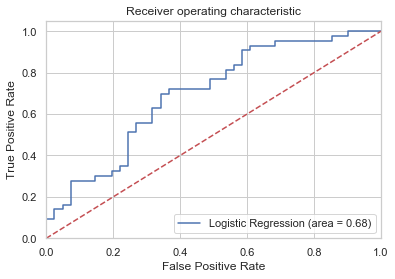

In [54]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
p=plt.figure()
p=plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
p=plt.plot([0, 1], [0, 1],'r--')
p=plt.xlim([0.0, 1.0])
p=plt.ylim([0.0, 1.05])
p=plt.xlabel('False Positive Rate')
p=plt.ylabel('True Positive Rate')
p=plt.title('Receiver operating characteristic')
p=plt.legend(loc="lower right")
#plt.savefig('Log_ROC')
plt.show()

The receiver operating characteristic (ROC) curve is another common tool used with binary classifiers. The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner).